# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Training Traffic_net on CIFAR10 dataset

---
## Step 0: Load The Data

In [1]:
import pickle
import scipy.stats as stats
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt

import random
import scipy.stats as stats
import numpy as np
import matplotlib.gridspec as gridspec
import tensorflow as tf
from sklearn.utils import shuffle
import time
import os

import helper as aux
import cnn_layers as cnnl
import models

from keras.datasets import cifar10

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [2]:
### Define your architecture here.
tf.reset_default_graph()

l_rate = 0.001
EPOCHS = 20 #Comes into play if no other early-stopping conditions triggers
BATCH_SIZE = 64
keep_probability = 0.5

output_count = 10

ch_count = 3 #image depth
l2_beta = 5e-5 #for L2-regularization

#Dictionary for conveniently pick later for visualizations
tf_names = {'samples': 'x', 
            'labels' : 'y', 
            'output' : 'logits', 
            'acc'    : 'accuracy', 
            'keep_p' : 'keep_prob'}

x = tf.placeholder(tf.float32, (None, 32, 32, ch_count), 
                   name=tf_names['samples'])

y = tf.placeholder(tf.int32, (None), name=tf_names['labels'])
one_hot_y = tf.one_hot(y, output_count)

keep_prob = tf.placeholder(tf.float32, name=tf_names['keep_p'])

# Turns out Exponential linear unit (ELU)
# gives a slight performance gain
logits, weights, model_name = models.traffic_net_v2_full_dropout(x, keep_prob, output_count, activation='elu')

#L2 regularization of weights
l2_regs = tf.add_n([ tf.nn.l2_loss(v) for v in weights ]) * l2_beta
logits = tf.identity(logits, name=tf_names['output'])

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y) + l2_regs
loss_operation = tf.reduce_mean(cross_entropy) 
optimizer = tf.train.AdamOptimizer(learning_rate=l_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name=tf_names['acc'])
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    X_data, y_data = shuffle(X_data, y_data)

    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        batch_y = y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples


Tensor("x:0", shape=(?, 32, 32, 3), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 16, 16, 64), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("dropout_2/mul:0", shape=(?, 3, 3, 192), dtype=float32)
Tensor("dropout_3/mul:0", shape=(?, 2048), dtype=float32)
Tensor("dropout_4/mul:0", shape=(?, 1024), dtype=float32)
Tensor("l2_normalize_2:0", shape=(?, 10), dtype=float32)


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Training

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# y_train.shape is 2d, (50000, 1). While Keras is smart enough to handle this
# it's a good idea to flatten the array.
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                  y_train, test_size=.2, random_state=0)

In [ ]:
best_accuracy = 0.0

run = 0

start = time.time()

print('Training..')

while run < 1 and best_accuracy < 1.0:

    save_file = './{}_{}.ckpt'.format(model_name, run)

    validation_accuracy = 0.0
    valid_acc_array = np.array([])
    train_acc_array = np.array([])
    no_improvement_count = 0
    
    sigma = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        i = 0

        #Defining early stopping.
        noit = 15 #Allowed number of iteration without improvement
        nois = 0.0015 #St dev of noit^ last validation accuracies
        while no_improvement_count < noit \
        and (len(valid_acc_array) < 5 or sigma > nois) \
        and validation_accuracy < 1.0 and i < EPOCHS:
            #feature_range = tqdm(range(0, num_examples, BATCH_SIZE))
            feature_range = range(0, num_examples, BATCH_SIZE)
            
            X_train, y_train = shuffle(X_train, y_train)

            for offset in feature_range:
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, 
                         feed_dict={x: batch_x, y: batch_y, 
                                    keep_prob: keep_probability})

            train_acc = evaluate(X_train, y_train)
            validation_accuracy = evaluate(X_valid, y_valid)
            train_acc_array = np.append(train_acc_array, train_acc)
            valid_acc_array = np.append(valid_acc_array, validation_accuracy)
            sigma = np.std(valid_acc_array[-noit:])

            if validation_accuracy > best_accuracy:
                best_accuracy = validation_accuracy
                saver.save(sess, save_file)
                no_improvement_count = 0
            elif no_improvement_count > 0 and len(valid_acc_array) > 0 \
            and validation_accuracy > valid_acc_array[-1]:
                # That's a bit controversial but allows net to recover 
                # after significant accuracy drops, when chosen tolerance 
                # may not be enough to recover
                no_improvement_count -= 1
            else:
                no_improvement_count += 1

            print("RUN {} | EPOCH | {} | train_acc = {:.4f} | val_acc = {:.4f} | valid_sigma 15: {:.4f}"
                  .format(run, i, train_acc, validation_accuracy, sigma))

            i += 1

        run += 1

aux.timing_stats_since(start=start, message='Training Complete. Global Best valid accuracy: {}\n'.format(best_accuracy))

### Testing

In [4]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        plt.axis('off')
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max)#, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max)#, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min)#, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest")#, cmap="gray")

In [7]:
save_file = './{}_0.ckpt'.format(model_name)
    
saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer()) #Lecture says no need to call this.
    saver.restore(sess, save_file)
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.716


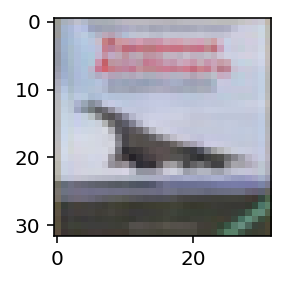

In [18]:
idx = random.randint(0, len(X_test))
img = X_test[idx]
plt.figure(figsize=(2,2))
plt.imshow(X_test[idx])


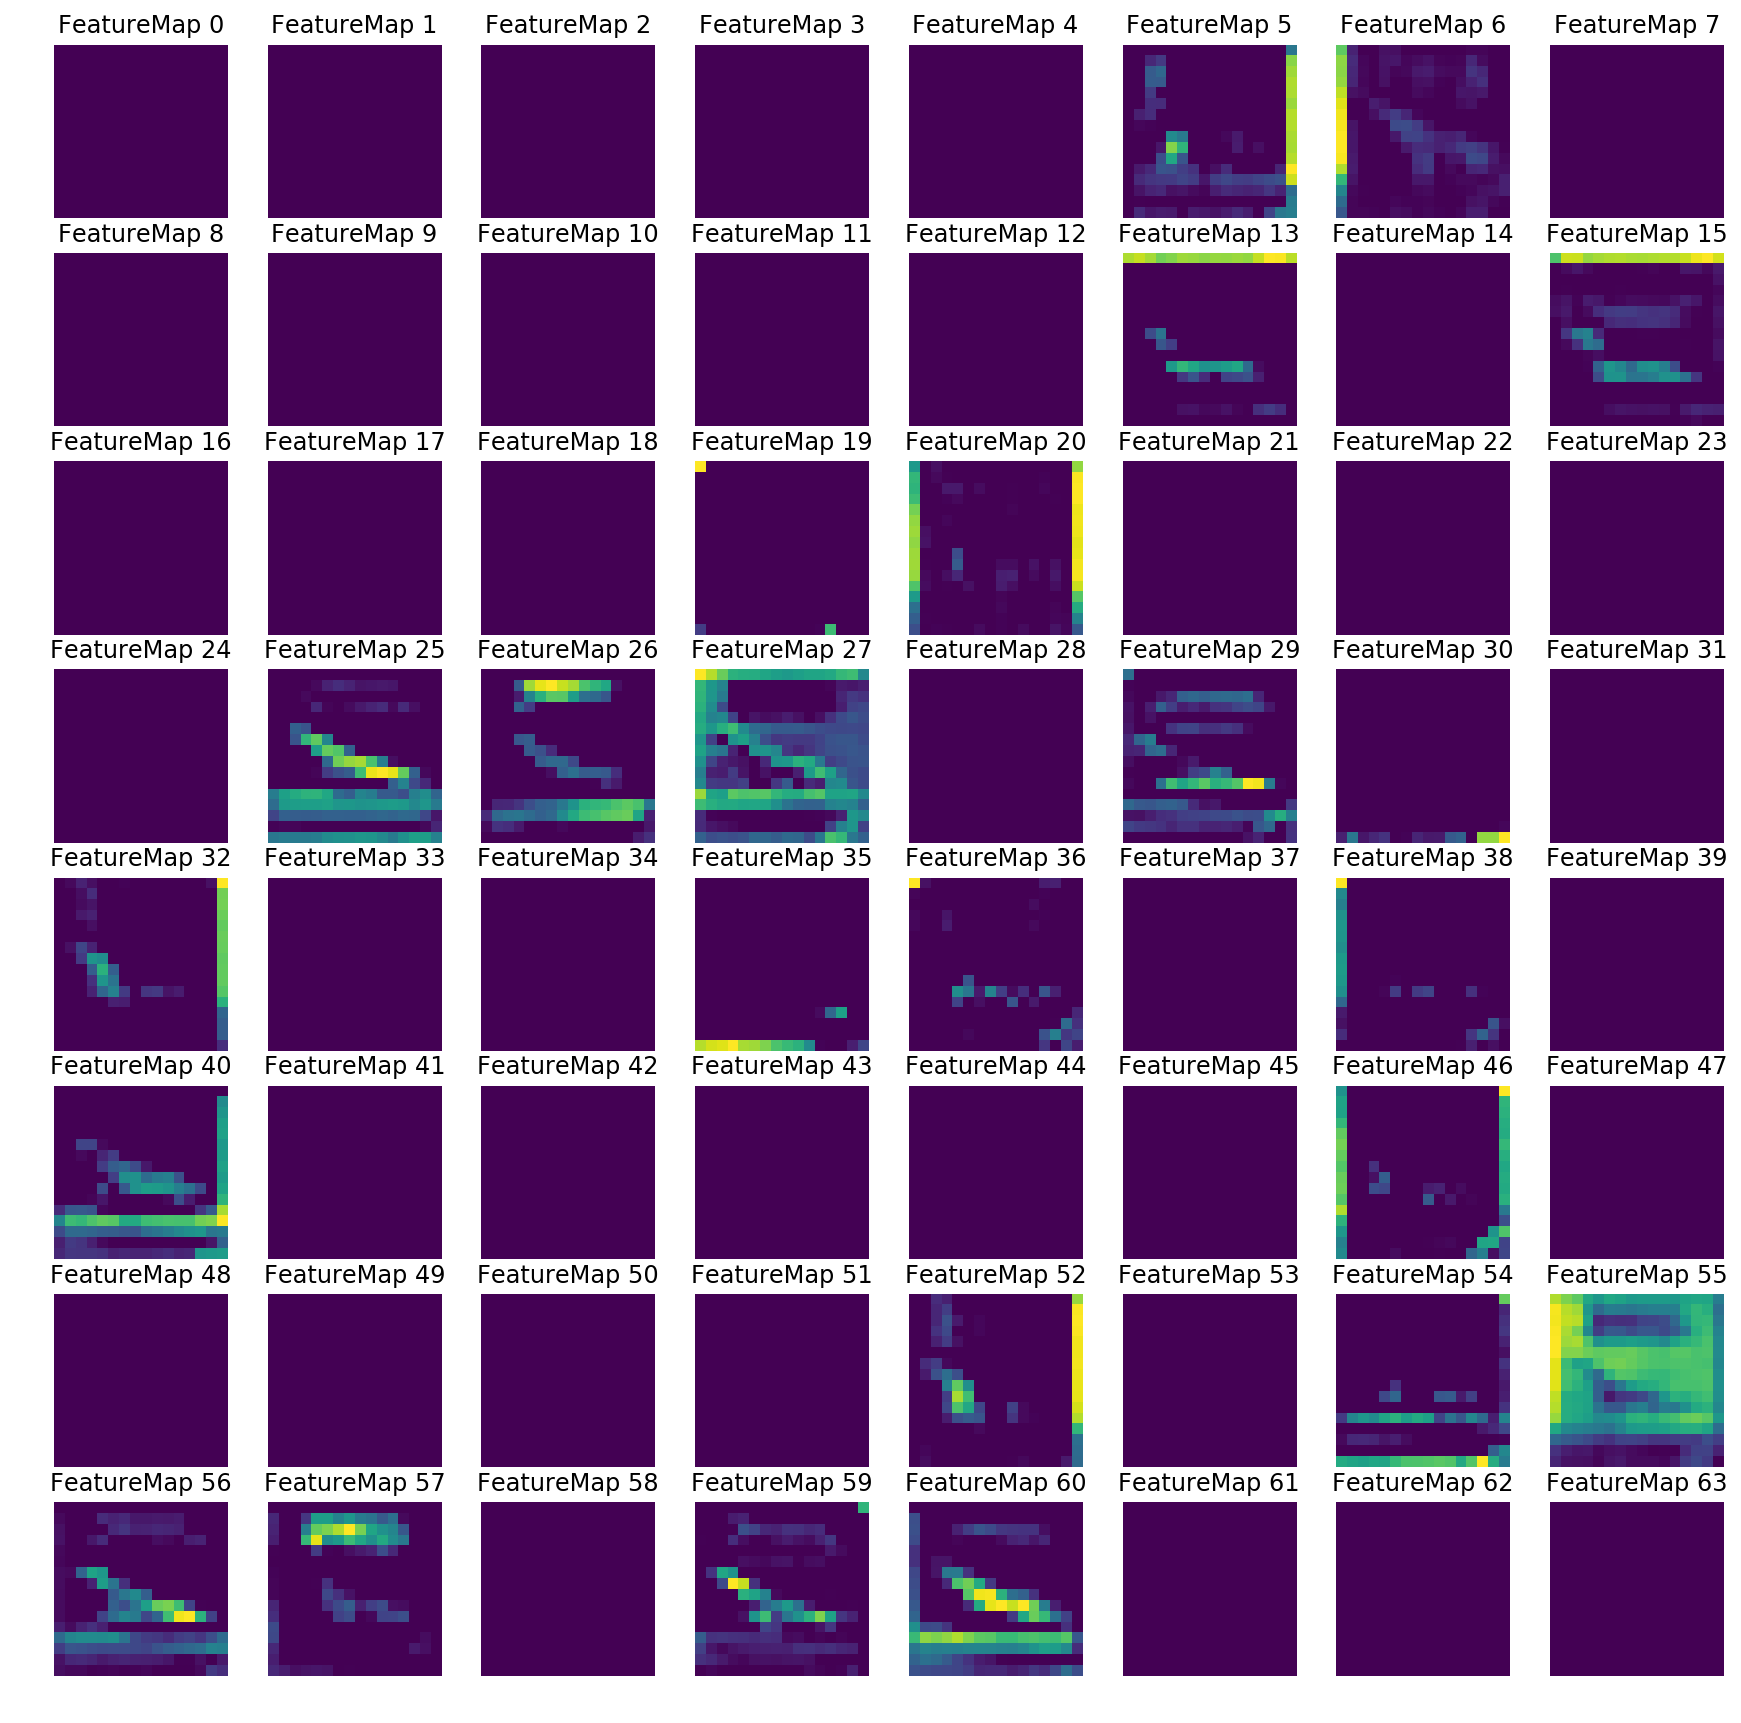

In [19]:
l_names = ['dropout/mul:0', 
           'dropout_1/mul:0',
           'dropout_2/mul:0',
           'dropout_3/mul:0',
           'dropout_4/mul:0',]


with tf.Session() as sess:
    saver.restore(sess, save_file)
    layer = sess.graph.get_tensor_by_name(l_names[0])
    outputFeatureMap(image_input=[img], tf_activation=layer)